The goal of this notebook is to tie the songs I know into the era that they are from. 

For now I am just focusing on non classical music, essentially 20th and 21st century.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load the music data
df = pd.read_csv('all.csv')

print(f"Total songs: {len(df)}")
print(f"Total unique artists: {df['Artist'].nunique()}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Total songs: 2223
Total unique artists: 863
Columns: ['#', 'Song', 'Artist', 'Popularity', 'BPM', 'Genres', 'Album', 'Album Date', 'Time', 'Dance', 'Energy', 'Acoustic', 'Instrumental', 'Happy', 'Speech', 'Live', 'Loud (Db)', 'Key', 'Time Signature', 'Added At', 'Spotify Track Id', 'Camelot', 'ISRC']

First few rows:


,#,Song,Artist,Popularity,BPM,Genres,Album,Album Date,Time,Dance,...,Happy,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Camelot,ISRC
0,1,Gabriel Ratchet,Deca,41,82,jazz rap,The Ocean,2013-09-23,03:11,68,...,76,30,10,-5,G Major,4,2025-08-03,4uQjhQYQyVZBKDtve537qZ,9B,TCABQ1315888
1,2,Lifestylez Ov Da Poor & Dangerous,Big L,45,85,"east coast hip hop, old school hip hop, hardco...",Lifestylez Ov Da Poor & Dangerous,1995-03-28,03:21,68,...,40,30,0,-9,D#/E♭ Minor,4,2025-08-03,5GseQckHgP7uWyaiCd5ZW3,2A,USSM10022975
2,3,Danger Zone,Big L,42,171,"east coast hip hop, old school hip hop, hardco...",Lifestylez Ov Da Poor & Dangerous,1995-03-28,03:36,52,...,34,30,20,-11,G Major,4,2025-08-03,0kU9oWqYnPeqEca3x2auV9,9B,USSM10022974
3,4,Hive (feat. Vince Staples & Casey Veggies),"Earl Sweatshirt,Vince Staples,Casey Veggies",55,145,"experimental hip hop, alternative hip hop,",Doris,2013-08-16,04:37,62,...,78,50,10,-7,C♯/D♭ Major,4,2025-08-03,6JKoTnberZoBgUuxa6l4Kh,3B,USQX91301103
4,5,King Kunta,Kendrick Lamar,73,107,"hip hop, west coast hip hop",To Pimp A Butterfly,2015-03-16,03:54,88,...,49,10,10,-5,F#/G♭ Minor,4,2025-08-03,0N3W5peJUQtI4eyR6GJT5O,11A,USUM71502494


In [2]:
# remove all songs with genre classical, the col is called Genres and is , seperated
mask_classical = df["Genres"].astype(str).str.contains("classical", case=False, na=False)
df = df[~mask_classical]
# remove all albums with the word Bach in it
mask_bach_album = df["Album"].astype(str).str.contains("Bach", case=False, na=False)
df = df[~mask_bach_album]

# remove all songs with genre choral or baroque
mask_choral = df["Genres"].astype(str).str.contains("choral", case=False, na=False)
mask_baroque = df["Genres"].astype(str).str.contains("baroque", case=False, na=False)
df = df[~(mask_choral | mask_baroque)]

In [3]:
# Primary/Clean artist: take first artist before comma
df["Cleaned_Artist"] = df["Artist"].astype(str).str.split(",").str[0].str.strip()

Songs: 1160, with inferred Year: 1027 (88.5%) [source: Album Date]

Artists by decade (count of artists with >1 songs):
Decade
1950     7
1960     9
1970    18
1980     6
1990    21
2000    38
2010    32
2020     8
dtype: int64

Top artists per decade (count > 1, top 100):

1950s:
  Ella Fitzgerald: 5
  Julie London: 4
  The Chordettes: 3
  The Four Freshmen: 3
  Nat King Cole: 2
  Charlie Parker: 2
  Miles Davis: 2

1960s:
  The Beatles: 30
  Stan Getz: 5
  The Doors: 4
  Bob Dylan: 3
  Louis Armstrong: 2
  Buffalo Springfield: 2
  Nat King Cole: 2
  Simon & Garfunkel: 2
  The Monkees: 2

1970s:
  Steely Dan: 9
  Elton John: 7
  Queen: 5
  Billy Joel: 5
  Stevie Wonder: 4
  Electric Light Orchestra: 4
  Earth: 3
  Bruce Springsteen: 3
  Neil Young: 2
  Eagles: 2
  Dire Straits: 2
  Bob Dylan: 2
  Steve Miller Band: 2
  Squeeze: 2
  The Hollies: 2
  The Beatles: 2
  Supertramp: 2
  Bee Gees: 2

1980s:
  Pixies: 6
  Tears For Fears: 5
  Billy Joel: 3
  Erasure: 2
  Duran Duran: 2
  Mich

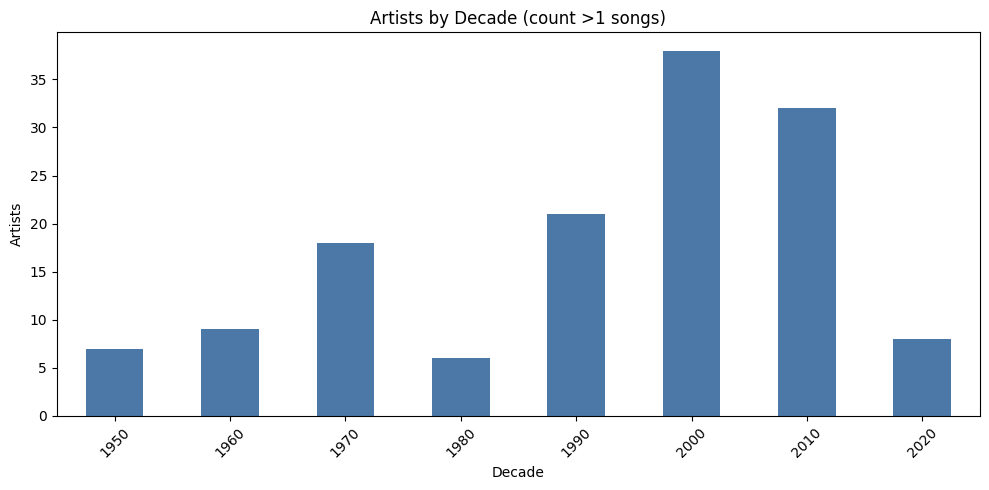

In [19]:
# Year & Decade inference + report (concise)
import re

# Candidate year/date columns sorted by preference
candidates = [
    "Album Date",  # dataset column
    "Release Date",
    "Released",
    "Album Year",
    "ReleaseYear",
    "Year",
    "Date",
]
existing = [c for c in candidates if c in df.columns]

used_column = None
for col in existing:
    # try datetime -> year
    s = pd.to_datetime(df[col], errors="coerce", utc=True).dt.year
    # fallback: numeric in plausible range
    if s.notna().sum() == 0:
        n = pd.to_numeric(df[col], errors="coerce")
        s = n.where((n >= 1800) & (n <= 2099))
    if s.notna().sum() > 0:
        df["Year"] = s
        used_column = col
        break

# Regex fallback from textual columns
if used_column is None:
    text = df[[c for c in ["Album", "Song", "Title", "Track", "Name"] if c in df.columns]]\
            .astype(str).agg(" ".join, axis=1)
    found = text.str.extract(r"((?<!\d)(18|19|20)\d{2}(?!\d))", expand=True)[0]
    df["Year"] = pd.to_numeric(found, errors="coerce")
    if df["Year"].notna().sum() > 0:
        used_column = "regex(Album/Song)"

# Decade
df["Decade"] = (pd.to_numeric(df["Year"], errors="coerce") // 10 * 10).astype("Int64")

# Report
total = len(df)
with_year = df["Year"].notna().sum()
print(f"Songs: {total}, with inferred Year: {with_year} ({(with_year/total if total else 0):.1%}) [source: {used_column or 'none'}]")

# Artists per decade (only artists with >1 songs in that decade)
artist_col = "Cleaned_Artist"
decade_artist_counts_raw = (
    df.dropna(subset=["Decade"]) 
      .groupby(["Decade", artist_col]).size()
)
# keep only artists with >1 songs within the decade
filtered = decade_artist_counts_raw[decade_artist_counts_raw > 1]
artist_decade_counts = filtered.groupby(level=0).size().sort_index()

print("\nArtists by decade (count of artists with >1 songs):")
print(artist_decade_counts)

# Top artists per decade (among those with >1 songs), top 100 for visibility
by_decade = filtered.sort_values(ascending=False).groupby(level=0).head(100)
print("\nTop artists per decade (count > 1, top 100):")
for decade, chunk in by_decade.groupby(level=0):
    print(f"\n{int(decade)}s:")
    for (d, a), cnt in chunk.items():
        print(f"  {a}: {cnt}")

# Plot artists-per-decade
plt.figure(figsize=(10, 5))
artist_decade_counts.plot(kind="bar", color="#4C78A8")
plt.title("Artists by Decade (count >1 songs)")
plt.xlabel("Decade")
plt.ylabel("Artists")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# I want to see all cols of the df
df.columns

Index(['#', 'Song', 'Artist', 'Popularity', 'BPM', 'Genres', 'Album',
       'Album Date', 'Time', 'Dance', 'Energy', 'Acoustic', 'Instrumental',
       'Happy', 'Speech', 'Live', 'Loud (Db)', 'Key', 'Time Signature',
       'Added At', 'Spotify Track Id', 'Camelot', 'ISRC', 'Cleaned_Artist',
       'Year', 'Decade'],
      dtype='object')

In [16]:
# get the bach ones
df[df["Cleaned_Artist"] == "Ella Fitzgerald"]

,#,Song,Artist,Popularity,BPM,Genres,Album,Album Date,Time,Dance,...,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Camelot,ISRC,Cleaned_Artist,Year,Decade
836,837,It's Only A Paper Moon,"Ella Fitzgerald,The Delta Rhythm Boys",55,114,"vocal jazz, jazz, swing music, jazz blues, big...",The War Years (1941-1947),1994-09-13,02:40,76,...,-17,A#/B♭ Major,4,2025-08-03,373yGkNo74RZgmQgTiR8xK,6B,USMC14572798,Ella Fitzgerald,1994.0,1990
873,874,Don't Get Around Much Anymore,Ella Fitzgerald,26,80,"vocal jazz, jazz, swing music, jazz blues, big...",Ella Fitzgerald Sings The Duke Ellington Song ...,1957-01-01,05:02,53,...,-14,F Major,4,2025-08-03,2AfM7mFmlGudZOBUJJzPb9,7B,USF095725670,Ella Fitzgerald,1957.0,1950
879,880,These Foolish Things (Remind Me Of You),"Ella Fitzgerald,Louis Armstrong",47,120,"vocal jazz, jazz, swing music, jazz blues, big...",Ella And Louis Again,1957-02-25,07:36,45,...,-19,G#/A♭ Major,5,2025-08-03,5s9tKuZkMiDxY1b6WIzHtL,4B,USPR35712074,Ella Fitzgerald,1957.0,1950
884,885,Misty,Ella Fitzgerald,49,88,"vocal jazz, jazz, swing music, jazz blues, big...",The Complete Piano Duets,2020-03-13,02:54,36,...,-14,G#/A♭ Minor,1,2025-08-03,4kF394GKEnI13QdZBM9mxM,1A,USPR36002481,Ella Fitzgerald,2020.0,2020
910,911,Love Is Here To Stay,Ella Fitzgerald,34,82,"vocal jazz, jazz, swing music, jazz blues, big...",Ella Fitzgerald Sings The George And Ira Gersh...,1959-01-01,03:56,40,...,-15,C Minor,4,2025-08-03,2sQaBIgG1D3Qshi0g5snI8,5A,USPR35982261,Ella Fitzgerald,1959.0,1950
911,912,"Bewitched, Bothered, And Bewildered",Ella Fitzgerald,52,61,"vocal jazz, jazz, swing music, jazz blues, big...",Ella Fitzgerald Sings The Rodgers And Hart Son...,1956-01-01,07:03,34,...,-17,F Major,4,2025-08-03,0gE63HwMeWgK30ONO4witM,7B,USUM71203595,Ella Fitzgerald,1956.0,1950
916,917,Love Is Here To Stay,"Ella Fitzgerald,Louis Armstrong",46,103,"vocal jazz, jazz, swing music, jazz blues, big...",Ella And Louis Again,1957-02-25,03:57,56,...,-13,G Major,4,2025-08-03,63qs0QjDLhV22OMdAxGaMQ,9B,USPR35712077,Ella Fitzgerald,1957.0,1950
